In [1]:
import numpy as np
from scipy.special import hankel1 as besselh
from scipy.special import iv as besseli
from scipy.special import kv as besselk
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy.optimize import newton, minimize_scalar
from multi_constants import *
from multi_equations import *
import pandas as pd


In [2]:
# CREATING THE A MATRIX

# Number of terms in approx of each region.
# All computations assume at least 2 regions.
NMK = [50, 50, 50]

size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
boundary_count = len(NMK) - 1

# Initialize the A matrix with zeros as well as b vector
A = np.zeros((size, size), dtype=complex)


###########################################################################
# Potential Matching

col = 0
row = 0
for bd in range(boundary_count):
    N = NMK[bd]
    M = NMK[bd + 1]
    if bd == (boundary_count - 1): # i-e boundary
        if bd == 0: # one cylinder
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + N + m] = - I_mk(n, m, bd) * Lambda_k(m, a[bd])
        else:
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                A[row + n][col + N + n] = (h - d[bd]) * R_2n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + 2*N + m] = - I_mk(n, m, bd) * Lambda_k(m, a[bd])
        row += N
            
    elif bd == 0:
        left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + N + m] = - I_nm(n, m, bd) * R_1n(m, a[bd], bd + 1)
                    A[row + n][col + N + M + m] = - I_nm(n, m, bd) * R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = I_nm(n, m, bd) * R_1n(n, a[bd], bd)
                A[row + m][col + N + m] = - (h - d[bd + 1]) * R_1n(m, a[bd], bd + 1)
                A[row + m][col + N + M + m] = - (h - d[bd + 1]) * R_2n(m, a[bd], bd + 1)
            row += M
        col += N
    else: # i-i boundary
        left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                A[row + n][col + N + n] = (h - d[bd]) * R_2n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + 2*N + m] = - I_nm(n, m, bd) * R_1n(m, a[bd], bd + 1)
                    A[row + n][col + 2*N + M + m] = - I_nm(n, m, bd) * R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = I_nm(n, m, bd) * R_1n(n, a[bd], bd)
                    A[row + m][col + N + n] = I_nm(n, m, bd) * R_2n(n, a[bd], bd)
                A[row + m][col + 2*N + m] = - (h - d[bd + 1]) * R_1n(m, a[bd], bd + 1)
                A[row + m][col + 2*N + M + m] = - (h - d[bd + 1]) * R_2n(m, a[bd], bd + 1)
            row += M
        col += 2 * N


###########################################################################
# Velocity Matching 

col = 0
for bd in range(boundary_count):
    N = NMK[bd]
    M = NMK[bd + 1]
    if bd == (boundary_count - 1): # i-e boundary
        if bd == 0: # one cylinder
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_mk(n, m, bd) * diff_R_1n(n, a[bd], bd)
                A[row + m][col + N + m] = h * diff_Lambda_k(m, a[bd])
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_mk(n, m, bd) * diff_R_1n(n, a[bd], bd)
                    A[row + m][col + N + n] = - I_mk(n, m, bd) * diff_R_2n(n, a[bd], bd)
                A[row + m][col + 2*N + m] = h * diff_Lambda_k(m, a[bd])
        row += N
            
    elif bd == 0:
        left_diag = d[bd] < d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = - (h - d[bd]) * diff_R_1n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + N + m] = I_nm(n, m, bd) * diff_R_1n(m, a[bd], bd + 1)
                    A[row + n][col + N + M + m] = I_nm(n, m, bd) * diff_R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_nm(n, m, bd) * diff_R_1n(n, a[bd], bd)
                A[row + m][col + N + m] = (h - d[bd + 1]) * diff_R_1n(m, a[bd], bd + 1)
                A[row + m][col + N + M + m] = (h - d[bd + 1]) * diff_R_2n(m, a[bd], bd + 1)
            row += M
        col += N
    else: # i-i boundary
        left_diag = d[bd] < d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = - (h - d[bd]) * diff_R_1n(n, a[bd], bd)
                A[row + n][col + N + n] = - (h - d[bd]) * diff_R_2n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + 2*N + m] = I_nm(n, m, bd) * diff_R_1n(m, a[bd], bd + 1)
                    A[row + n][col + 2*N + M + m] = I_nm(n, m, bd) * diff_R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_nm(n, m, bd) * diff_R_1n(n, a[bd], bd)
                    A[row + m][col + N + n] = - I_nm(n, m, bd) * diff_R_2n(n, a[bd], bd)
                A[row + m][col + 2*N + m] = (h - d[bd + 1]) * diff_R_1n(m, a[bd], bd + 1)
                A[row + m][col + 2*N + M + m] = (h - d[bd + 1]) * diff_R_2n(m, a[bd], bd + 1)
            row += M
        col += 2 * N


###########################################################################
if False:
    
 rows, cols = np.nonzero(A)
 plt.figure(figsize=(6, 6))
 plt.scatter(cols, rows, color='blue', marker='o', s=100) 
 plt.gca().invert_yaxis() 
 plt.xticks(range(A.shape[1]))
 plt.yticks(range(A.shape[0]))

 cols = [NMK[0]]
 for i in range(1, boundary_count):
    cols.append(cols[-1] + NMK[i])
    cols.append(cols[-1] + NMK[i])
 cols.append(cols[-1] + NMK[-1])

 for val in cols:
    plt.axvline(val-0.5, color='black', linestyle='-', linewidth=1) 
    plt.axhline(val-0.5, color='black', linestyle='-', linewidth=1) 

 # for y in range(0, A.shape[0], 3):
    # plt.axhline(y-0.5, color='black', linestyle='-', linewidth=1) 

 plt.grid(True)
 plt.title('Non-Zero Entries of the Matrix')
 plt.xlabel('Column Index')
 plt.ylabel('Row Index')
 plt.show()
 # plt.imshow(np.real(A))
 # plt.colorbar()
 # print(A[:3,:3])
 # print(R_1n_2(3, a1) * A_nm(1, 3))
 # print(R_2n_2(3, a1) * A_nm(1, 3))


In [3]:
b = np.zeros(size, dtype=complex)

index = 0

# potential matching
for boundary in range(boundary_count):
    if boundary == (boundary_count - 1): # i-e boundary
        for n in range(NMK[-2]):
            b[index] = b_potential_end_entry(n, boundary)
            index += 1
    else: # i-i boundary
        for n in range(NMK[boundary + (d[boundary] < d[boundary + 1])]): # iterate over eigenfunctions for smaller h-d
            b[index] = b_potential_entry(n, boundary)
            index += 1

# velocity matching
for boundary in range(boundary_count):
    if boundary == (boundary_count - 1): # i-e boundary
        for n in range(NMK[-1]):
            b[index] = b_velocity_end_entry(n, boundary)
            index += 1
    else: # i-i boundary
        for n in range(NMK[boundary + (d[boundary] > d[boundary + 1])]): # iterate over eigenfunctions for larger h-d
            b[index] = b_velocity_entry(n, boundary)
            index += 1


In [4]:
X = linalg.solve(A,b)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40332/2932172903.py:1: LinAlgWarning: Ill-conditioned matrix (rcond=7.78439e-59): result may not be accurate.
  X = linalg.solve(A,b)


In [5]:
hydro_terms = np.zeros((size - NMK[-1]), dtype=complex)

col = 0
for n in range(NMK[0]):
    hydro_terms[n] = int_R_1n(0, n)* X[n] * z_n_d(n)
col += NMK[0]
for i in range(1, boundary_count):
    M = NMK[i]
    for m in range(M):
        hydro_terms[col + m] = int_R_1n(i, m)* X[col + m] * z_n_d(m)
        hydro_terms[col + M + m] = int_R_2n(i, m)* X[col + M + m] * z_n_d(m)
    col += 2 * M

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    hydro_p_terms[i] = heaving[i] * int_phi_p_i_no_coef(i)

hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real
hydro_coef_imag = hydro_coef.imag/omega

# find maximum heaving radius
max_rad = a[0]
for i in range(boundary_count - 1, 0, -1):
    if heaving[i]:
        max_rad = a[i]
        break

hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef

print("real", hydro_coef_real)
print("imag", hydro_coef_imag)
print(hydro_coef_nondim)


real 1.5643974752350684
imag 0.42140847760793815
(0.4994585662226589+0.3678506712390027j)


In [6]:
# Split up the Cs into groups depending on which equation they belong to.
Cs = []
row = 0
Cs.append(X[:NMK[0]])
row += NMK[0]
for i in range(1, boundary_count):
    Cs.append(X[row: row + NMK[i] * 2])
    row += NMK[i] * 2
Cs.append(X[row:])

In [7]:
def phi_h_n_inner_func(n, r, z):
    return (Cs[0][n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0)

def phi_h_m_i_func(i, m, r, z):
    return (Cs[i][m] * R_1n(m, r, i) + Cs[i][NMK[i] + m] * R_2n(m, r, i)) * Z_n_i(m, z, i)

def phi_e_k_func(k, r, z):
    return Cs[-1][k] * Lambda_k(k, r) * Z_n_e(k, z)

r_vec = lambda spatial_res: np.linspace(2 * a[-1] / spatial_res, 2*a[-1], spatial_res)
z_vec = lambda spatial_res: np.linspace(-h, 0, spatial_res)
R, Z = np.meshgrid(r_vec(spatial_res=50), z_vec(spatial_res=50))
 

regions = []
regions.append((R <= a[0]) & (Z < -d[0]))
for i in range(1, boundary_count):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
regions.append(R > a[-1])

phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

for n in range(NMK[0]):
    temp_phiH = phi_h_n_inner_func(n, R[regions[0]], Z[regions[0]])
    phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_phiH = phi_h_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

for k in range(NMK[-1]):
    temp_phiH = phi_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

phi_p_i_vec = np.vectorize(phi_p_i)

phiP[regions[0]] = heaving[0] * phi_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    phiP[regions[i]] = heaving[i] * phi_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
phiP[regions[-1]] = 0

phi = phiH + phiP


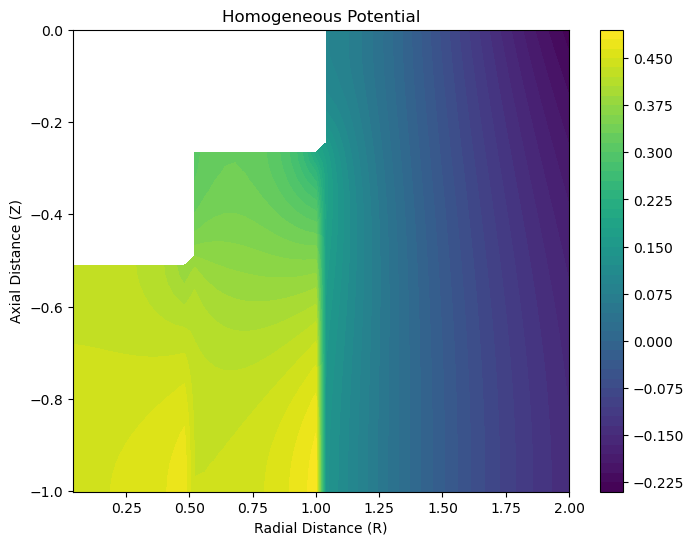

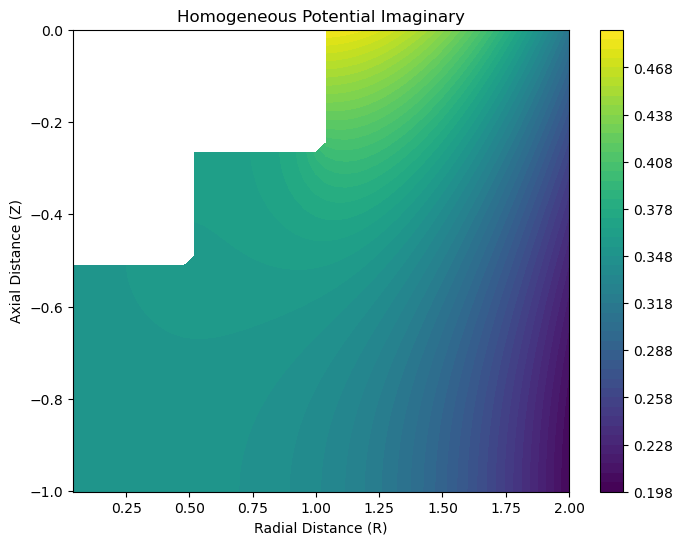

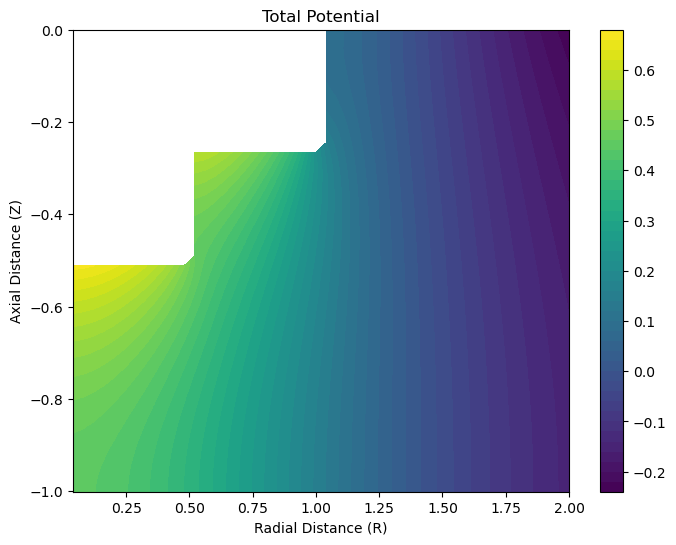

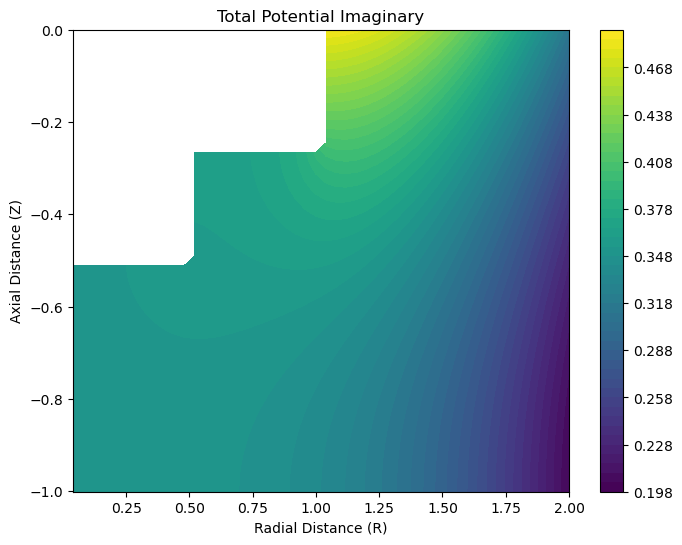

In [8]:
def plot_potential(field, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

plot_potential(np.real(phiH), R, Z, 'Homogeneous Potential')
plot_potential(np.imag(phiH), R, Z, 'Homogeneous Potential Imaginary')

#plot_potential(np.real(phiP), R, Z, 'Particular Potential')
#plot_potential(np.imag(phiP), R, Z, 'Particular Potential Imaginary')

plot_potential(np.real(phi), R, Z, 'Total Potential')
plot_potential(np.imag(phi), R, Z, 'Total Potential Imaginary')




In [9]:
def v_r_inner_func(n, r, z):
    return (Cs[0][n] * diff_R_1n(n, r, 0)) * Z_n_i(n, z, 0)

def v_r_m_i_func(i, m, r, z):
    return (Cs[i][m] * diff_R_1n(m, r, i) + Cs[i][NMK[i] + m] * diff_R_2n(m, r, i)) * Z_n_i(m, z, i)

def v_r_e_k_func(k, r, z):
    return Cs[-1][k] * diff_Lambda_k(k, r) * Z_n_e(k, z)

def v_z_inner_func(n, r, z):
    return (Cs[0][n] * R_1n(n, r, 0)) * diff_Z_n_i(n, z, 0)

def v_z_m_i_func(i, m, r, z):
    return (Cs[i][m] * R_1n(m, r, i) + Cs[i][NMK[i] + m] * R_2n(m, r, i)) * diff_Z_n_i(m, z, i)

def v_z_e_k_func(k, r, z):
    return Cs[-1][k] * Lambda_k(k, r) * diff_Z_n_e(k, z)

In [10]:
vr = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vrH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vrP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

vz = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vzH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vzP = np.full_like(R, np.nan + np.nan*1j, dtype=complex)

for n in range(NMK[0]):
    temp_vrH = v_r_inner_func(n, R[regions[0]], Z[regions[0]])
    temp_vzH = v_z_inner_func(n, R[regions[0]], Z[regions[0]])
    if n == 0:
        vrH[regions[0]] = temp_vrH
        vzH[regions[0]] = temp_vzH
    else:
        vrH[regions[0]] = vrH[regions[0]] + temp_vrH
        vzH[regions[0]] = vzH[regions[0]] + temp_vzH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_vrH = v_r_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        temp_vzH = v_z_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        if m == 0:
            vrH[regions[i]] = temp_vrH
            vzH[regions[i]] = temp_vzH
        else:
            vrH[regions[i]] = vrH[regions[i]] + temp_vrH
            vzH[regions[i]] = vzH[regions[i]] + temp_vzH

for k in range(NMK[-1]):
    temp_vrH = v_r_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    temp_vzH = v_z_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    if k == 0:
        vrH[regions[-1]] = temp_vrH
        vzH[regions[-1]] = temp_vzH
    else:
        vrH[regions[-1]] = vrH[regions[-1]] + temp_vrH
        vzH[regions[-1]] = vzH[regions[-1]] + temp_vzH

vr_p_i_vec = np.vectorize(diff_r_phi_p_i)
vz_p_i_vec = np.vectorize(diff_z_phi_p_i)

vrP[regions[0]] = heaving[0] * vr_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
vzP[regions[0]] = heaving[0] * vz_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    vrP[regions[i]] = heaving[i] * vr_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
    vzP[regions[i]] = heaving[i] * vz_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
vrP[regions[-1]] = 0
vzP[regions[-1]] = 0

vr = vrH + vrP
vz = vzH + vzP

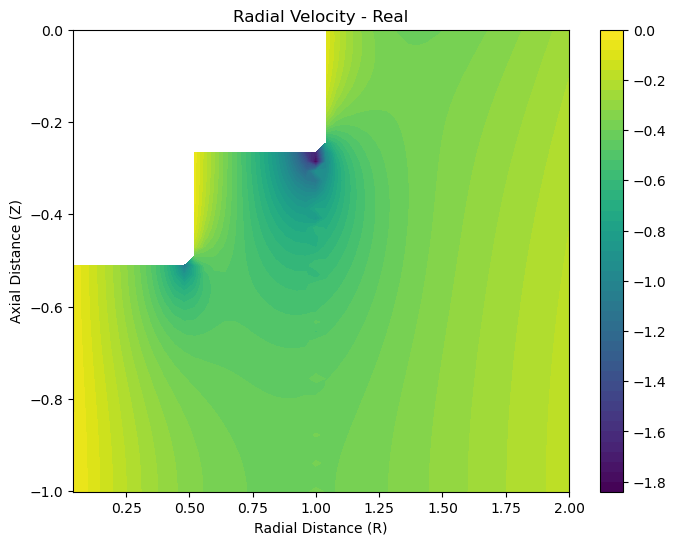

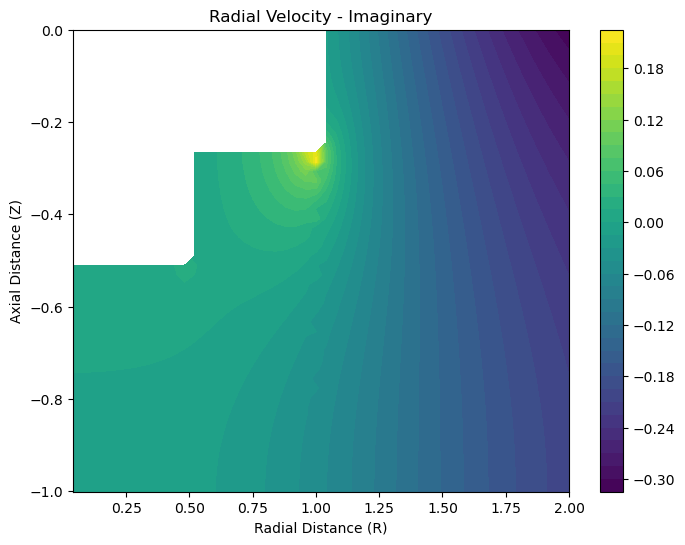

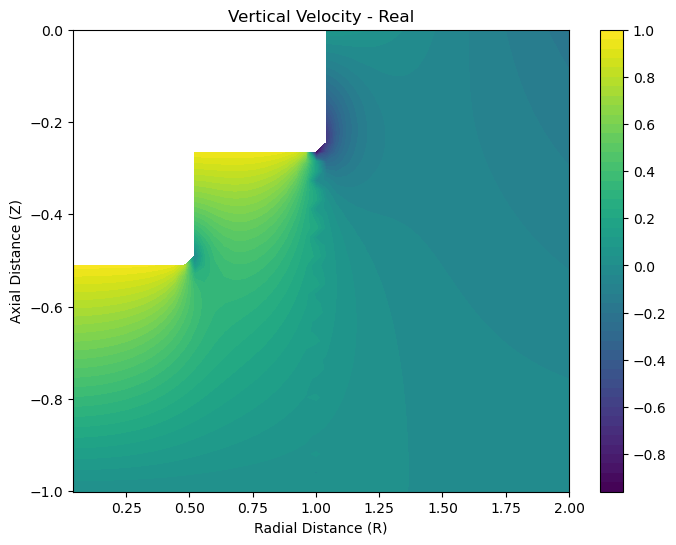

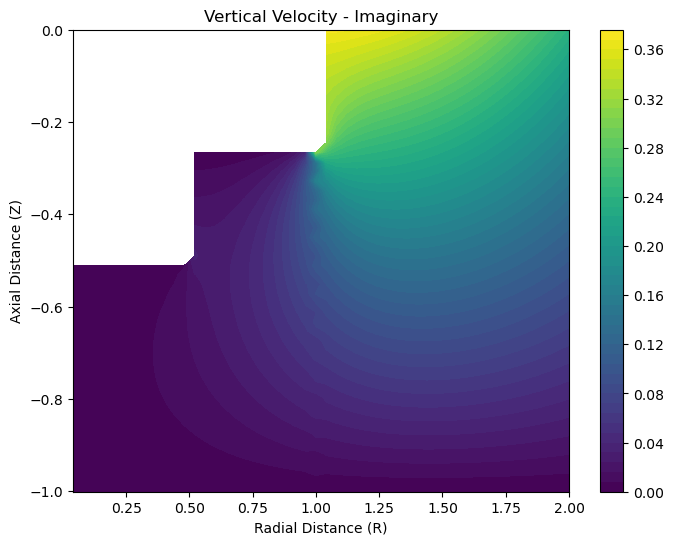

In [11]:
plot_potential(np.real(vr), R, Z, 'Radial Velocity - Real')
plot_potential(np.imag(vr), R, Z, 'Radial Velocity - Imaginary')
plot_potential(np.real(vz), R, Z, 'Vertical Velocity - Real')
plot_potential(np.imag(vz), R, Z, 'Vertical Velocity - Imaginary')

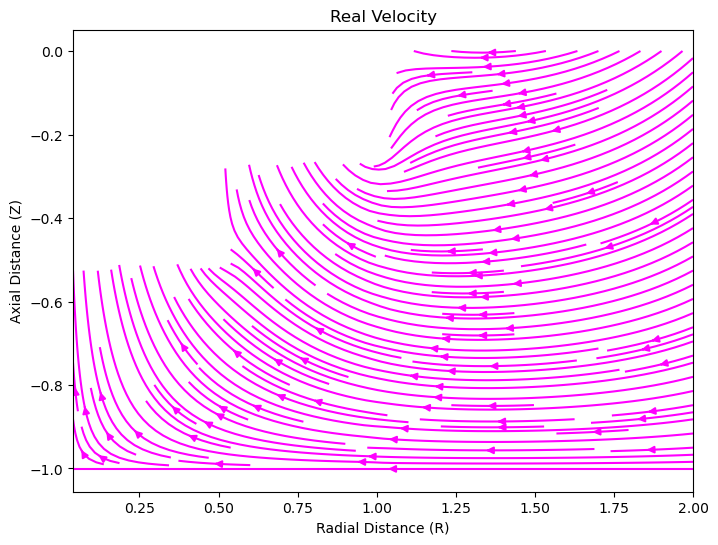

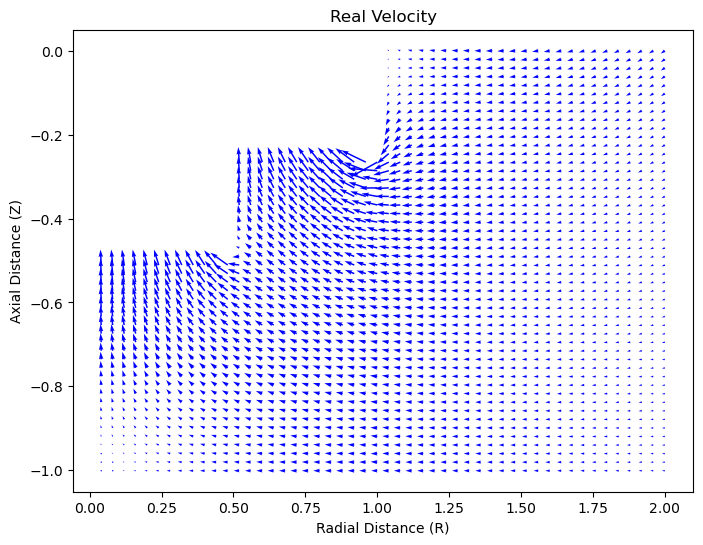

In [12]:
def plot_velocity_stream(v_r, v_z, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.streamplot(R, Z, v_r, v_z, color='magenta', density=2)
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

def plot_velocity_quiver(v_r, v_z, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.quiver(R, Z, v_r, v_z, color='blue')
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

plot_velocity_stream(np.real(vr), np.real(vz), R, Z, 'Real Velocity')
plot_velocity_quiver(np.real(vr), np.real(vz), R, Z, 'Real Velocity')

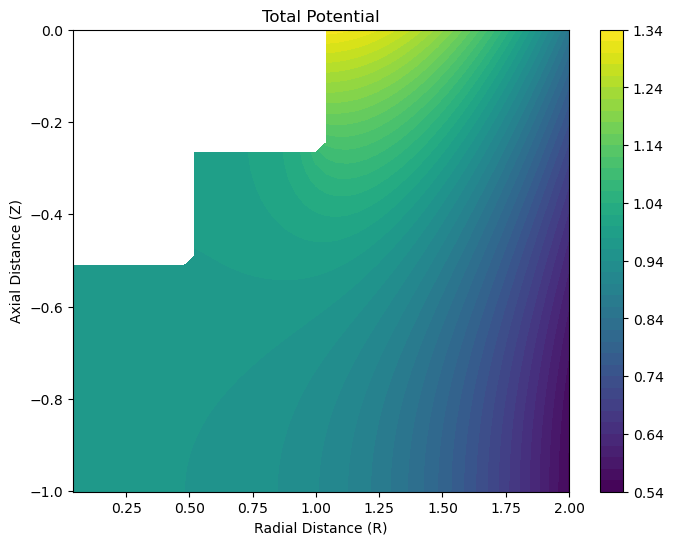

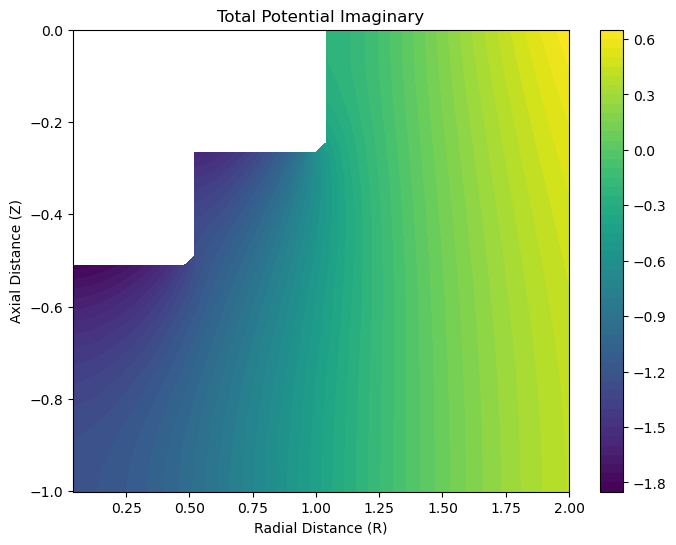

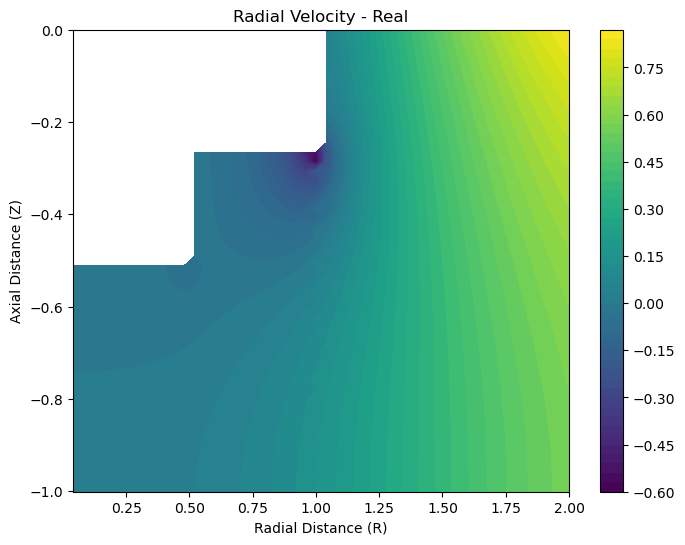

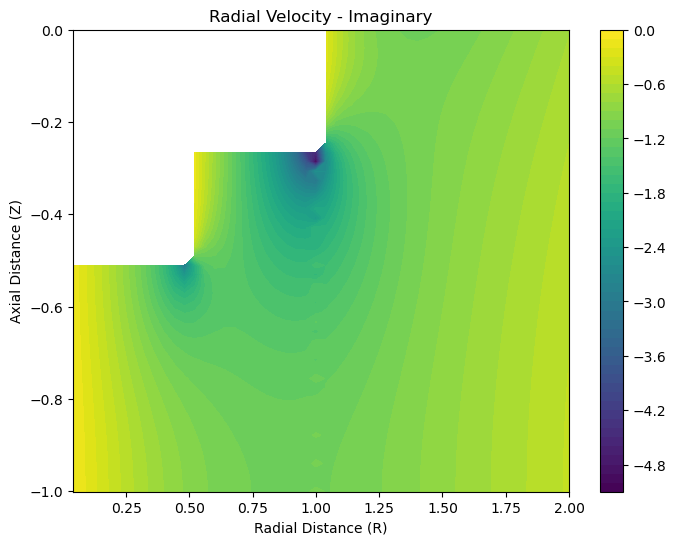

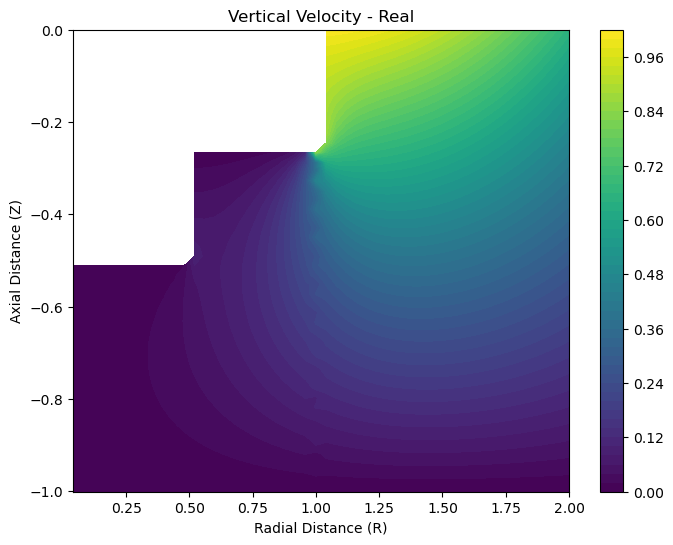

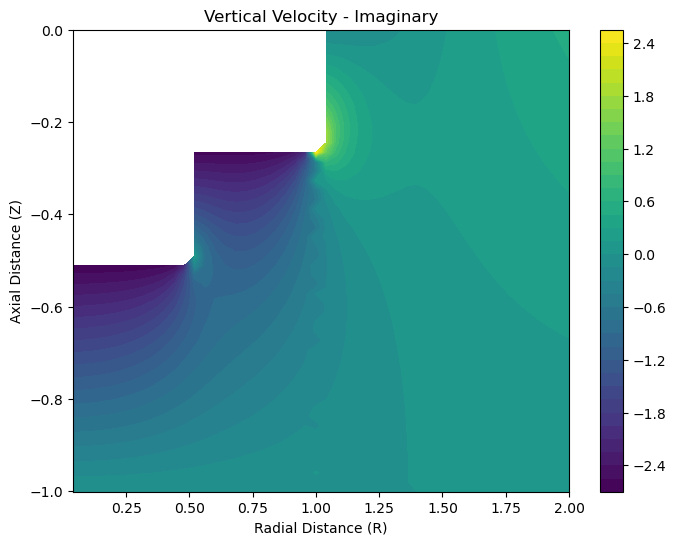

In [13]:
# Capytaine should output something that is off by a factor of (-) i * omega. The following graphs do that:
# Figure out why vrc factor is different from phic and vrz (no negative sign)
# Swapping the heave dof direction in capytaine flips all the signs of its graphs
# so still inconsistent

phic = - phi * 1j * omega
vrc = vr * 1j * omega
vzc = - vz * 1j * omega

plot_potential(np.real(phic), R, Z, 'Total Potential')
plot_potential(np.imag(phic), R, Z, 'Total Potential Imaginary')
plot_potential(np.real(vrc), R, Z, 'Radial Velocity - Real')
plot_potential(np.imag(vrc), R, Z, 'Radial Velocity - Imaginary')
plot_potential(np.real(vzc), R, Z, 'Vertical Velocity - Real')
plot_potential(np.imag(vzc), R, Z, 'Vertical Velocity - Imaginary')


In [14]:
# Study Convergence, assume that every entry of NMK is 50.
# Strategy: Make large A matrices, b vector, then select submatrices/vectors
# Solve for hydro-coefficients like before
# Plot hydro-coefficients vs. coefficient count

def hydro_coeff_calc(s, blocks, C):
    hydro_terms = np.zeros((s * (blocks - 1)), dtype=complex)

    col = 0
    for n in range(s):
        hydro_terms[n] = int_R_1n(0, n)* C[n] * z_n_d(n)
    col += s
    for i in range(1, boundary_count):
        for m in range(s):
            hydro_terms[col + m] = int_R_1n(i, m)* C[col + m] * z_n_d(m)
            hydro_terms[col + s + m] = int_R_2n(i, m)* C[col + s + m] * z_n_d(m)
        col += 2 * s
    
    hydro_p_terms = np.zeros(boundary_count, dtype=complex)
    for i in range(boundary_count):
        hydro_p_terms[i] = heaving[i] * int_phi_p_i_no_coef(i)
    
    hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
    hydro_coef_real = hydro_coef.real
    hydro_coef_imag = hydro_coef.imag/omega
    
    hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef
    
    return hydro_coef_nondim


hydro_nondim_real = []
hydro_nondim_imag = []

blocks = 2 * boundary_count
for s in range(1, 51):
    alpha = np.zeros((blocks * s, blocks * s), dtype=complex)
    beta = np.zeros(blocks * s, dtype=complex)
    for rowblock in range(blocks):
        for i in range(s):
            beta[i + s * rowblock] = b[i + 50 * rowblock]
            for colblock in range(blocks):
                for j in range(s):
                    alpha[i + s * rowblock][j + s * colblock] = A[i + 50 * rowblock][j + 50 * colblock]
    C = linalg.solve(alpha,beta)
    hcnd = hydro_coeff_calc(s, blocks, C)
    hydro_nondim_real.append(hcnd.real)
    hydro_nondim_imag.append(hcnd.imag)


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40332/2752143507.py:45: LinAlgWarning: Ill-conditioned matrix (rcond=2.06989e-17): result may not be accurate.
  C = linalg.solve(alpha,beta)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40332/2752143507.py:45: LinAlgWarning: Ill-conditioned matrix (rcond=1.4123e-18): result may not be accurate.
  C = linalg.solve(alpha,beta)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40332/2752143507.py:45: LinAlgWarning: Ill-conditioned matrix (rcond=9.81925e-20): result may not be accurate.
  C = linalg.solve(alpha,beta)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40332/2752143507.py:45: LinAlgWarning: Ill-conditioned matrix (rcond=6.66144e-21): result may not be accurate.
  C = linalg.solve(alpha,beta)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40332/2752143507.py:45: LinAlgWarning: Ill-conditioned matrix (rcond=4.60248e-22): result may not be accurate.
  C = linalg.solve(alpha,be

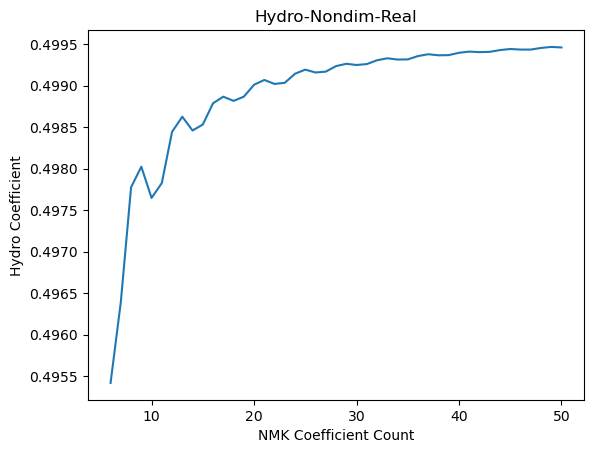

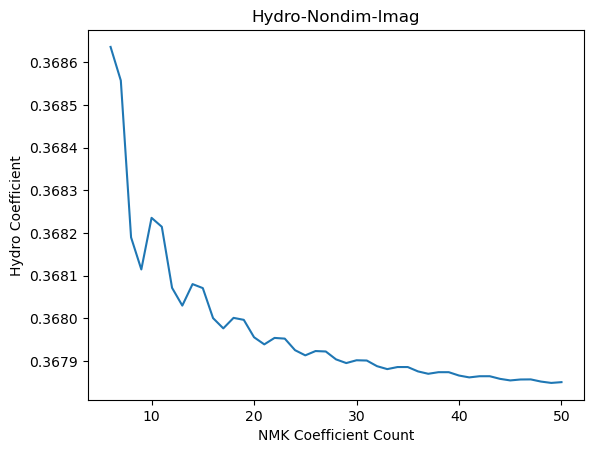

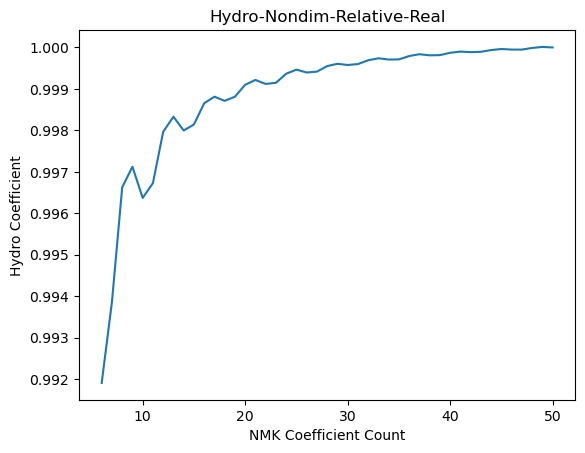

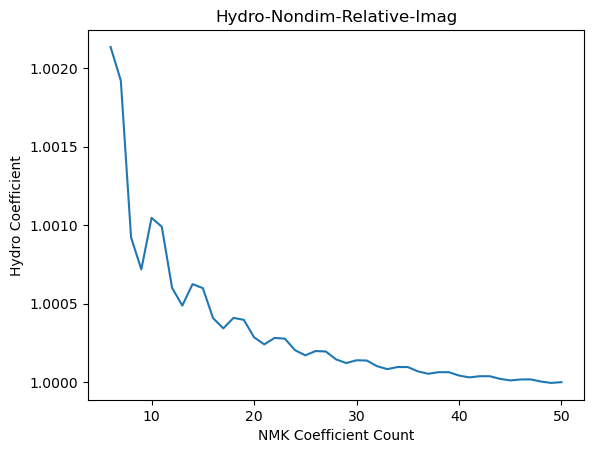

In [15]:
def plot_hydros(xs, ys, title):
    #plt.figure(figsize=(8, 6))
    plt.plot(xs, ys)
    plt.title(title)
    plt.xlabel('NMK Coefficient Count')
    plt.ylabel('Hydro Coefficient')
    plt.show()

xs = list(range(1,51))
#plot_hydros(xs, hydro_nondim_real, "Hydro-Nondim-Real")
#plot_hydros(xs, hydro_nondim_imag, "Hydro-Nondim-Imag")

idealr = hydro_nondim_real[-1]
ideali = hydro_nondim_imag[-1]

relative_real = list(map(lambda x: (x/idealr), hydro_nondim_real))
relative_imag = list(map(lambda x: (x/ideali), hydro_nondim_imag))

#plot_hydros(xs, relative_real, "Hydro-Nondim-Relative-Real")
#plot_hydros(xs, relative_imag, "Hydro-Nondim-Relative-Imag")

#plot while removing most extreme initial values
plot_hydros(xs[5:], hydro_nondim_real[5:], "Hydro-Nondim-Real")
plot_hydros(xs[5:], hydro_nondim_imag[5:], "Hydro-Nondim-Imag")
plot_hydros(xs[5:], relative_real[5:], "Hydro-Nondim-Relative-Real")
plot_hydros(xs[5:], relative_imag[5:], "Hydro-Nondim-Relative-Imag")

In [16]:
# Refer to original MEEM file for some extra plotting functions.